<a href="https://colab.research.google.com/github/2303a52252-collab/Exp-AI/blob/main/ASS_04_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lime shap

✅ Model Accuracy: 0.9517426273458445

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       389
           1       0.98      0.98      0.98       399
           2       0.94      0.93      0.93       394
           3       0.95      0.93      0.94       310

    accuracy                           0.95      1492
   macro avg       0.95      0.95      0.95      1492
weighted avg       0.95      0.95      0.95      1492



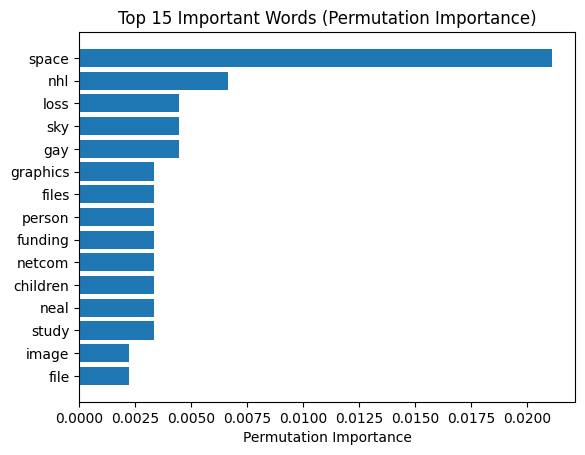

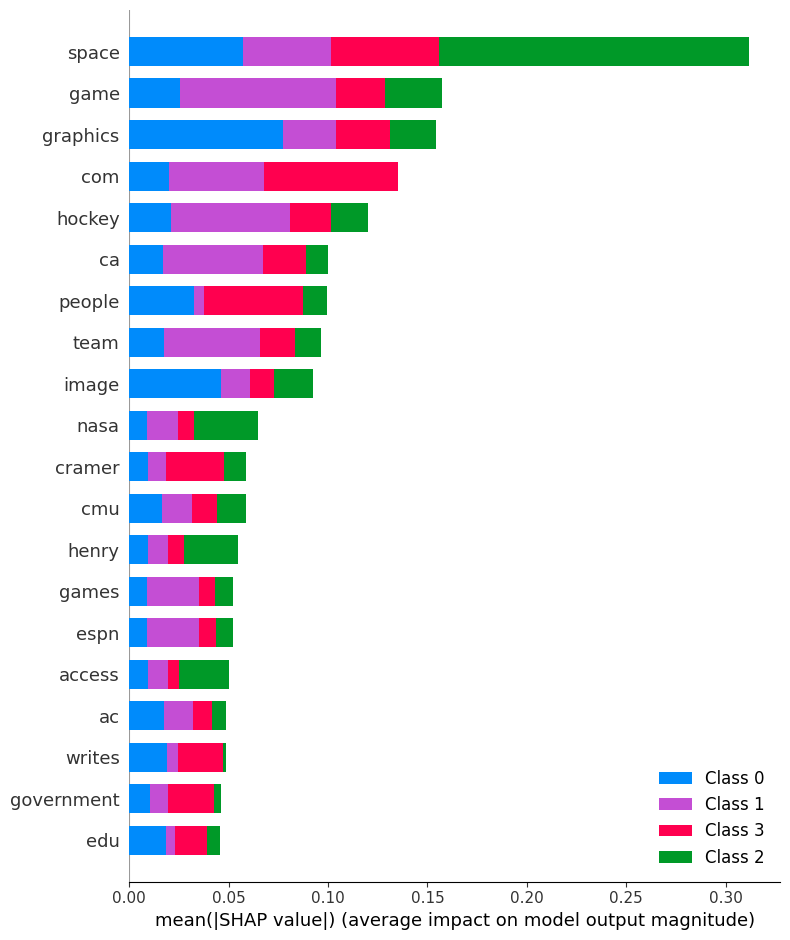

/usr/local/lib/python3.12/dist-packages/shap/plots/_force.py:211: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

import shap
import lime
from lime.lime_text import LimeTextExplainer
categories = ['sci.space', 'comp.graphics', 'rec.sport.hockey', 'talk.politics.misc']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

X_train, y_train = newsgroups_train.data, newsgroups_train.target
X_test, y_test = newsgroups_test.data, newsgroups_test.target
model = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=5000),  # limit to 5000 features for speed
    LogisticRegression(max_iter=1000)
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
vectorizer = model.named_steps['tfidfvectorizer']
clf = model.named_steps['logisticregression']

X_test_tfidf = vectorizer.transform(X_test).toarray()
X_sample, y_sample = resample(X_test_tfidf, y_test, n_samples=300, random_state=42)
result = permutation_importance(clf, X_sample, y_sample,
                                n_repeats=3, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[-15:]
plt.barh(np.array(vectorizer.get_feature_names_out())[sorted_idx],
         result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Top 15 Important Words (Permutation Importance)")
plt.show()
X_test_tfidf = vectorizer.transform(X_test)
explainer = shap.LinearExplainer(clf, X_test_tfidf, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test_tfidf)
shap.summary_plot(shap_values, features=X_test_tfidf, feature_names=vectorizer.get_feature_names_out())
shap.initjs()
doc_index = 0
predicted_class_index = model.predict(X_test)[doc_index]
shap.force_plot(explainer.expected_value[predicted_class_index],
                shap_values[doc_index].values,
                feature_names=vectorizer.get_feature_names_out())
class_names = newsgroups_train.target_names
explainer_lime = LimeTextExplainer(class_names=class_names)
idx1 = 1
exp1 = explainer_lime.explain_instance(X_test[idx1],
                                       model.predict_proba,
                                       num_features=10)
exp1.show_in_notebook(text=True)
idx2 = 10
exp2 = explainer_lime.explain_instance(X_test[idx2],
                                       model.predict_proba,
                                       num_features=10)
exp2.show_in_notebook(text=True)
print("\n--- Comparative Analysis ---")
print("1. PI shows global most important words across dataset (efficient after limiting features).")
print("2. SHAP provides both global (summary) and local (force plot) explanations.")
print("3. LIME gives interpretable word-level contributions for individual documents.")
print("4. PI & SHAP global overlap on frequent strong predictors (like 'space', 'game').")
print("5. SHAP local and LIME local often highlight similar keywords for a single doc.")
print("6. LIME is simpler but more approximate, SHAP is mathematically consistent.")
print("7. Logistic Regression + TF-IDF captures interpretable word features effectively.")
print("8. Common words across methods confirm model stability.")
print("9. Some rare words influence LIME strongly but less in SHAP.")
print("10. Overall, SHAP + PI give robust global view, LIME is best for local debugging.")